In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas_datareader.data as web
from datetime import datetime 
start = datetime(1962, 1, 1)
end = datetime(2016, 12, 31)

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import accuracy_score

In [4]:
xle = web.DataReader("XLE", 'yahoo', start, end) # Energy
xlu = web.DataReader("XLU", 'yahoo', start, end) # Utilities
xlk = web.DataReader("XLK", 'yahoo', start, end) # Technology
xlb = web.DataReader("XLB", 'yahoo', start, end) # Materials
xlp = web.DataReader("XLP", 'yahoo', start, end) # Consumer Staples
xly = web.DataReader("XLY", 'yahoo', start, end) # Consumer Discretionary
xli = web.DataReader("XLI", 'yahoo', start, end) # Industrial
xlv = web.DataReader("XLV", 'yahoo', start, end) # HealthCare
spy = web.DataReader("SPY", 'yahoo', start, end) # S&P 500

In [5]:
def makeXy(data, year):
    d = data[datetime(year,1,1):datetime(2015,12,31)]
    
    # Time variables
    d['t'] = np.arange(len(d))
    for p in range(2,7):
        d['t'+str(p)]=d['t']**p
    
    # Yesterday and lagged variables    
    forlags = d[:]
    for v in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
        for lag in range(1,11):
            d[str(v)+'_lag'+str(lag)] = forlags[v].shift(lag)

    #Powers of yesterday variables
    for v in ['Open_lag1', 'High_lag1', 'Low_lag1', 'Close_lag1', 'Volume_lag1', 'Adj Close_lag1']:
        for p in range(2,4):
            d[str(v)+'^'+str(p)]=d[str(v)]**p

    # Drop Nan        
    d = d.dropna()

    d['y']=np.where(d['Open']<d['Close'],1,0)
    
    # Endogenous and Exogenous components
    X = d.ix[:,6:-1]
    y = d['y']
    
    return(X,y)

In [17]:
def Trydata(data, year):
    """Creates X and y for the fund 'data', starting with the year 'year'. 
    Applies Logit, Neural Network, Random Forest, Gradient Boosting, and ARIMA models 
    to X and y"""
    
    (X,y) = makeXy(data, year)
    
    Xnorm = normalize(X)
    kf = KFold(n_splits=5, shuffle=True)
    
    # Logit
    print('Logit Regression')
    Cvalues = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000] 
    for v in Cvalues:
        logit = LogisticRegression(C=v)
        print('C is '+str(v))
        score = np.mean(cross_val_score(logit, Xnorm, y, scoring='accuracy', cv=kf))
        print(score)
    print('')
    
    # Neural Network
    print('Neural Network')
    alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
    for a in alpha_values:
        neural = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10), alpha=a)
        print('alpha is '+str(a))
        score = np.mean(cross_val_score(neural, Xnorm, y, scoring='accuracy', cv=kf))
        print(score)
    print('')
    
    # Random Forest
    print('Random Forest')
    trees = [5, 10, 15, 20, 25, 30, 50, 100, 150]
    for t in trees:
        forest = RandomForestClassifier(n_estimators=t)
        print('t is '+str(t))
        score = np.mean(cross_val_score(forest, Xnorm, y, scoring='accuracy', cv=kf))
        print(score)
    print('')
    
    # Gradient Boosting
    print('Gradient Boosting')
    for t in trees:
        gbm = GradientBoostingClassifier(n_estimators=t,verbose=True)
        print('t is '+str(t))
        score = np.mean(cross_val_score(gbm, Xnorm, y, scoring='accuracy', cv=kf))
        print(score)
    print('')
    
    # ARIMA
    d = data[datetime(year,1,1):datetime(2015,12,31)]
    d['d'] = d['Close'] - d['Open']
    ts = d['d']
    d['y']=np.where(d['Open']<d['Close'],1,0) 
    
    model = ARIMA(ts, order=(2, 1, 2))  
    results_ARIMA = model.fit()  
    plt.plot(ts)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    
    d['ARIMApredicted_d'] = pd.Series(results_ARIMA.fittedvalues, copy=True)
    d['ARIMApredicted_y']=np.where(d['ARIMApredicted_d']>0,1,0)
    print('ARIMA')
    acc = accuracy_score(d['y'],d['ARIMApredicted_y'])
    print(acc)
    print('')
    
    return('Done!')

In [7]:
def makeXtest(data, year):
    ext_d = data[datetime(year, 1, 1):datetime(2016,12,31)]
    
    # Time variables 
    ext_d['t'] = np.arange(len(ext_d))
    for p in range(2,7):
        ext_d['t'+str(p)]=ext_d['t']**p
    
    # Yesterday and lagged variables    
    forlags = ext_d[:]
    for v in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
        for lag in range(1,11):
            ext_d[str(v)+'_lag'+str(lag)] = forlags[v].shift(lag)

    #Powers of yesterday variables
    for v in ['Open_lag1', 'High_lag1', 'Low_lag1', 'Close_lag1', 'Volume_lag1', 'Adj Close_lag1']:
        for p in range(2,4):
            ext_d[str(v)+'^'+str(p)]=ext_d[str(v)]**p

    # Drop Nan        
    ext_d = ext_d.dropna()

    # Xtest
    Xtest = ext_d.ix['2016-1-1':,6:]
    
    return(Xtest)

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.278779263239


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

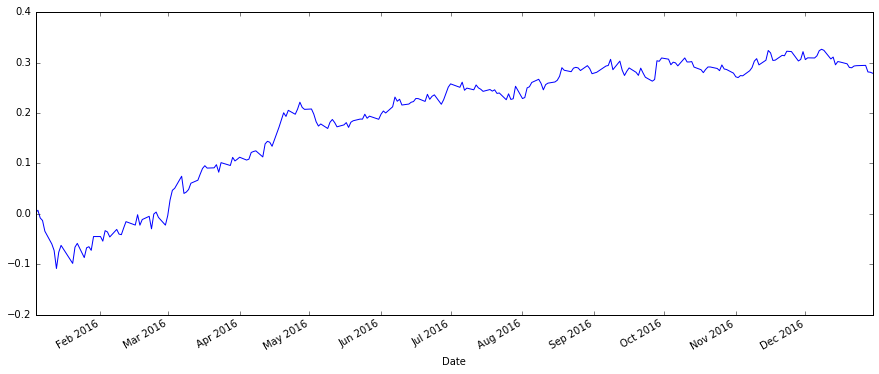

In [68]:
# Making Logit Predictions for XLE data starting at 2015:
(X,y) = makeXy(xle, 2015)
Xtest = makeXtest(xle, 2015)
test_xle = xle[datetime(2016, 1, 1):datetime(2016,12,31)]

logit = LogisticRegression(C=0.03)
logit.fit(X,y)
test_xle['logitpredicted_y'] = logit.predict(Xtest)

test_xle['pl'] = np.where(test_xle['logitpredicted_y']==1, (test_xle['Close']-test_xle['Open'])/test_xle['Open'], (test_xle['Open']-test_xle['Close'])/test_xle['Open'])
test_xle['pl_cumsum'] = np.cumsum(test_xle['pl'])

print(sum(test_xle['pl']))
test_xle['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.32427165083


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

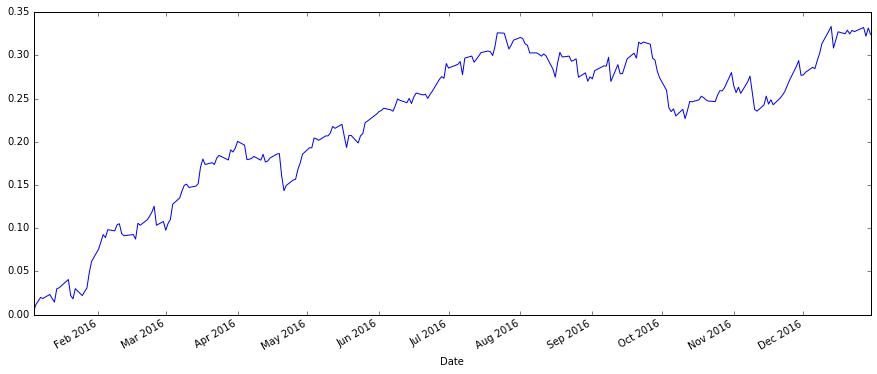

In [31]:
# Making Logit Predictions for XLU data starting at 2014:
(X,y) = makeXy(xlu, 2014)
Xtest = makeXtest(xlu, 2014)
test_xlu = xlu[datetime(2016, 1, 1):datetime(2016,12,31)]

logit = LogisticRegression(C=1)
logit.fit(X,y)
test_xlu['logitpredicted_y'] = logit.predict(Xtest)

test_xlu['pl'] = np.where(test_xlu['logitpredicted_y']==1, (test_xlu['Close']-test_xlu['Open'])/test_xlu['Open'], (test_xlu['Open']-test_xlu['Close'])/test_xlu['Open'])
test_xlu['pl_cumsum'] = np.cumsum(test_xlu['pl'])

print(sum(test_xlu['pl']))
test_xlu['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

      Iter       Train Loss   Remaining Time 
         1           1.3590            0.14s
         2           1.3383            0.13s
         3           1.3176            0.12s
         4           1.2984            0.12s
         5           1.2819            0.11s
         6           1.2694            0.11s
         7           1.2523            0.10s
         8           1.2390            0.10s
         9           1.2269            0.09s
        10           1.2087            0.09s
        20           1.1091            0.04s
        30           1.0271            0.00s
0.048617258191


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

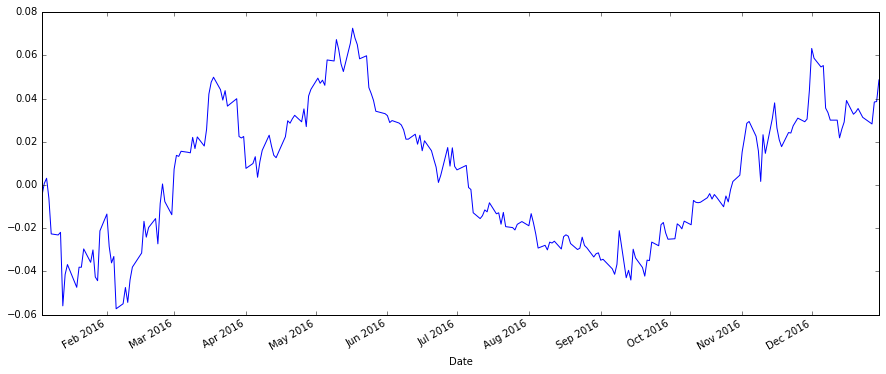

In [42]:
# Making GBM Predictions for XLK data starting at 2014:
(X,y) = makeXy(xlk, 2014)
Xtest = makeXtest(xlk, 2014)
test_xlk = xlk[datetime(2016, 1, 1):datetime(2016,12,31)]

gbm = GradientBoostingClassifier(n_estimators=30,verbose=True)
gbm.fit(X,y)
test_xlk['gbmpredicted_y'] = gbm.predict(Xtest)

test_xlk['pl'] = np.where(test_xlk['gbmpredicted_y']==1, (test_xlk['Close']-test_xlk['Open'])/test_xlk['Open'], (test_xlk['Open']-test_xlk['Close'])/test_xlk['Open'])
test_xlk['pl_cumsum'] = np.cumsum(test_xlk['pl'])

print(sum(test_xlk['pl']))
test_xlk['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.123769219015


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

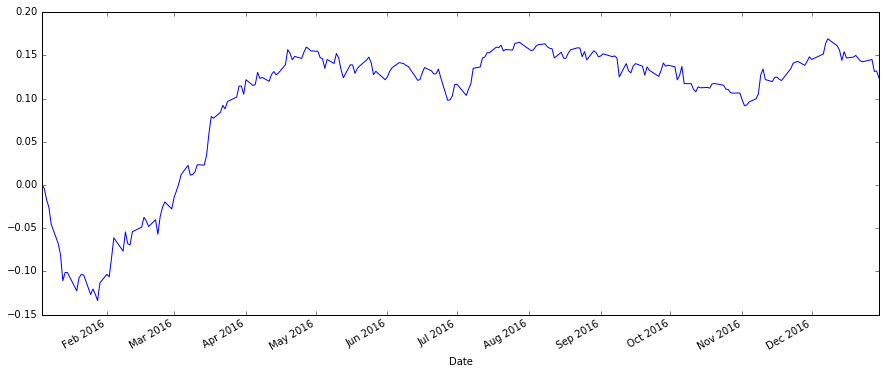

In [51]:
# Making Logit Predictions for XLB data starting at 2015:
(X,y) = makeXy(xlb, 2015)
Xtest = makeXtest(xlb, 2015)
test_xlb = xlb[datetime(2016, 1, 1):datetime(2016,12,31)]

logit = LogisticRegression(C=0.01)
logit.fit(X,y)
test_xlb['logitpredicted_y'] = logit.predict(Xtest)

test_xlb['pl'] = np.where(test_xlb['logitpredicted_y']==1, (test_xlb['Close']-test_xlb['Open'])/test_xlb['Open'], (test_xlb['Open']-test_xlb['Close'])/test_xlb['Open'])
test_xlb['pl_cumsum'] = np.cumsum(test_xlb['pl'])

print(sum(test_xlb['pl']))
test_xlb['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.16464064576


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

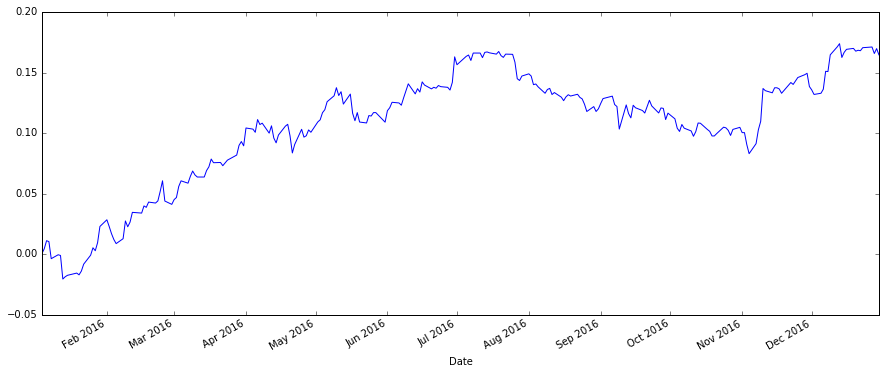

In [74]:
# Making Logit Predictions for XLP data starting at 2009:
(X,y) = makeXy(xlp, 2009)
Xtest = makeXtest(xlp, 2009)
test_xlp = xlp[datetime(2016, 1, 1):datetime(2016,12,31)]

logit = LogisticRegression(C=0.01)
logit.fit(X,y)
test_xlp['logitpredicted_y'] = logit.predict(Xtest)

test_xlp['pl'] = np.where(test_xlp['logitpredicted_y']==1, (test_xlp['Close']-test_xlp['Open'])/test_xlp['Open'], (test_xlp['Open']-test_xlp['Close'])/test_xlp['Open'])
test_xlp['pl_cumsum'] = np.cumsum(test_xlp['pl'])

print(sum(test_xlp['pl']))
test_xlp['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.130902177711


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

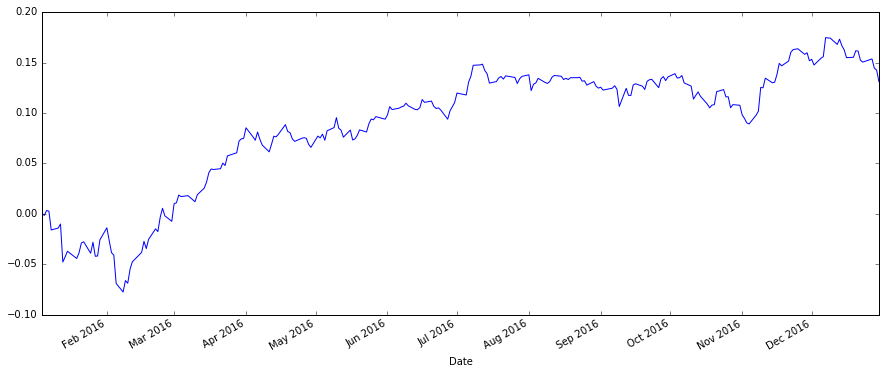

In [62]:
# Making Logit Predictions for XLY data starting at 2012:
(X,y) = makeXy(xly, 2012)
Xtest = makeXtest(xly, 2012)
test_xly = xly[datetime(2016, 1, 1):datetime(2016,12,31)]

logit = LogisticRegression(C=0.01)
logit.fit(X,y)
test_xly['logitpredicted_y'] = logit.predict(Xtest)

test_xly['pl'] = np.where(test_xly['logitpredicted_y']==1, (test_xly['Close']-test_xly['Open'])/test_xly['Open'], (test_xly['Open']-test_xly['Close'])/test_xly['Open'])
test_xly['pl_cumsum'] = np.cumsum(test_xly['pl'])

print(sum(test_xly['pl']))
test_xly['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.270714696153


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

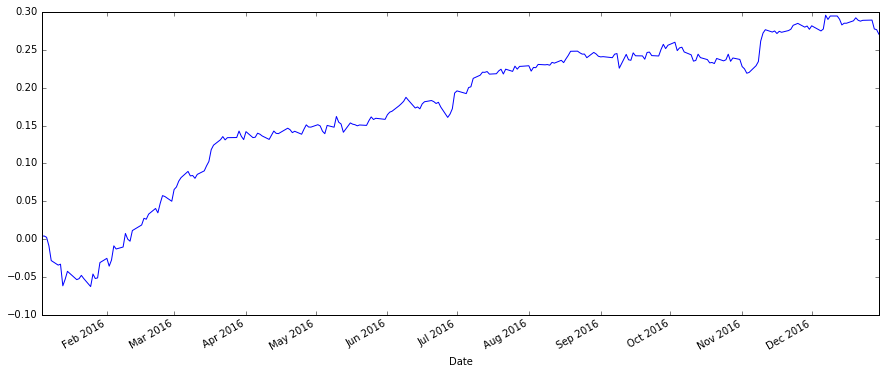

In [66]:
# Making Neural Network Predictions for XLI data starting at 2012:
(X,y) = makeXy(xli, 2012)
Xtest = makeXtest(xli, 2012)
test_xli = xli[datetime(2016, 1, 1):datetime(2016,12,31)]

neural = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10), alpha=10)
neural.fit(X,y)
test_xli['neuralpredicted_y'] = neural.predict(Xtest)

test_xli['pl'] = np.where(test_xli['neuralpredicted_y']==1, (test_xli['Close']-test_xli['Open'])/test_xli['Open'], (test_xli['Open']-test_xli['Close'])/test_xli['Open'])
test_xli['pl_cumsum'] = np.cumsum(test_xli['pl'])

print(sum(test_xli['pl']))
test_xli['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.0766005344769


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

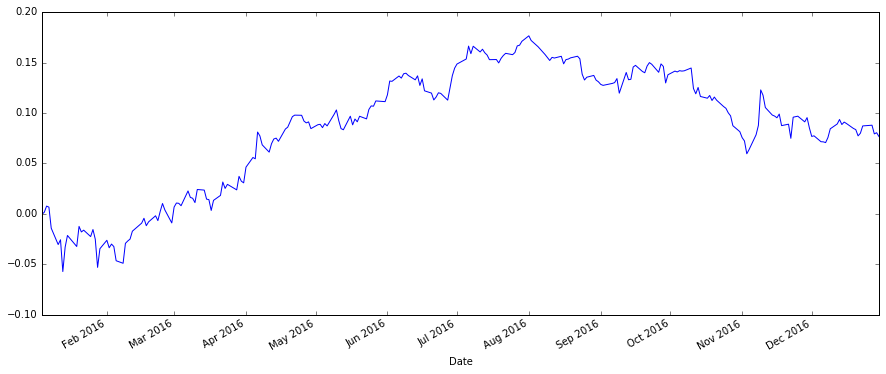

In [72]:
# Making Logit Predictions for XLV data starting at 2011:
(X,y) = makeXy(xlv, 2011)
Xtest = makeXtest(xlv, 2011)
test_xlv = xlv[datetime(2016, 1, 1):datetime(2016,12,31)]

logit = LogisticRegression(C=0.01)
logit.fit(X,y)
test_xlv['logitpredicted_y'] = logit.predict(Xtest)

test_xlv['pl'] = np.where(test_xlv['logitpredicted_y']==1, (test_xlv['Close']-test_xlv['Open'])/test_xlv['Open'], (test_xlv['Open']-test_xlv['Close'])/test_xlv['Open'])
test_xlv['pl_cumsum'] = np.cumsum(test_xlv['pl'])

print(sum(test_xlv['pl']))
test_xlv['pl_cumsum'].plot()

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0.0745404987453


/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

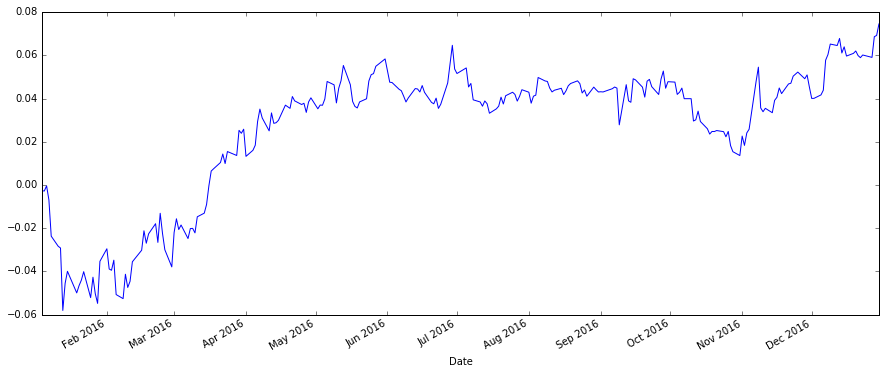

In [84]:
# Making Random Forest for SPY data starting at 2009:
(X,y) = makeXy(spy, 2009)
Xtest = makeXtest(spy, 2009)
test_spy = spy[datetime(2016, 1, 1):datetime(2016,12,31)]

forest = RandomForestClassifier(n_estimators=25)
forest.fit(X,y)
test_spy['forestpredicted_y'] = forest.predict(Xtest)

test_spy['pl'] = np.where(test_spy['forestpredicted_y']==1, (test_spy['Close']-test_spy['Open'])/test_spy['Open'], (test_spy['Open']-test_spy['Close'])/test_spy['Open'])
test_spy['pl_cumsum'] = np.cumsum(test_spy['pl'])

print(sum(test_spy['pl']))
test_spy['pl_cumsum'].plot()

In [ ]:
for fund in [xle, xlu, xlk, xlb, xlp, xly, xli, xlv, spy]:
    for yr in [2009, 2010, 2011, 2012, 2013, 2014, 2015]:
        print(str(fund)+', start at '+str(yr))
        Trydata(fund, yr)

In [106]:
# Bringing all predictions together
fundnames = ['xle', 'xlu', 'xlk', 'xlb', 'xlp', 'xly', 'xli', 'xlv', 'spy']
testdata = [test_xle, test_xlu, test_xlk, test_xlb, test_xlp, test_xly, test_xli, test_xlv, test_spy]
    
for i in range(len(fundnames)):
    for var in testdata[i]:
        testdata[i][fundnames[i]+'_'+str(var)] = testdata[i][var]
        del testdata[i][var]

TEST = test_xle
for dat in [test_xlu, test_xlk, test_xlb, test_xlp, test_xly, test_xli, test_xlv, test_spy]:
    TEST = pd.concat([TEST, dat], axis=1)

/Users/dani/Applications/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [132]:
TEST.tail()

,xle_Open,xle_High,xle_Low,xle_Close,xle_Volume,xle_Adj Close,xle_logitpredicted_y,xle_pl,xle_pl_cumsum,xlu_Open,...,spy_Adj Close,spy_forestpredicted_y,spy_pl,spy_pl_cumsum,pl_strategy1,pl_strategy1_cumsum,pl_strategy2,pl_strategy2_cumsum,pl_strategy3,pl_strategy3_cumsum
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,76.300003,76.510002,76.180000,76.349998,6398100,75.894744,1,0.000655,0.293682,48.680000,...,224.732324,1,0.001242,0.060150,0.011179,1.488253,0.010640,1.772666,0.006548,1.425451
2016-12-27,76.470001,76.779999,76.400002,76.519997,10008900,76.063729,1,0.000654,0.294336,48.419998,...,225.289896,0,-0.001106,0.059044,0.009955,1.498208,0.016912,1.789579,0.008580,1.434031
2016-12-28,76.690002,76.720001,75.629997,75.690002,8093700,75.238683,1,-0.013040,0.281296,48.680000,...,223.427985,0,0.009578,0.068622,-0.086199,1.412009,-0.091384,1.698195,-0.051916,1.382115
2016-12-29,75.580002,75.800003,75.269997,75.540001,6697400,75.089576,1,-0.000529,0.280767,48.380001,...,223.378214,0,0.000579,0.069201,-0.005212,1.406797,0.011193,1.709388,0.012351,1.394466
2016-12-30,75.470001,75.889999,75.080002,75.320000,8853300,74.870887,1,-0.001988,0.278779,48.930000,...,222.561759,0,0.005340,0.074540,-0.048058,1.358739,-0.059257,1.650131,-0.028516,1.365950


In [123]:
# SPY Long-Only
TEST['pl_strategy1'] = 9*((TEST['spy_Close'] - TEST['spy_Open'])/TEST['spy_Open'])
TEST['pl_strategy1_cumsum'] = np.cumsum(TEST['pl_strategy1'])

In [ ]:
# All Long-Only
TEST['pl_strategy2'] = ((TEST['xle_Close'] - TEST['xle_Open'])/TEST['xle_Open']) \
        + ((TEST['xlu_Close'] - TEST['xlu_Open'])/TEST['xlu_Open']) \
        + ((TEST['xlk_Close'] - TEST['xlk_Open'])/TEST['xlk_Open']) \
        + ((TEST['xlb_Close'] - TEST['xlb_Open'])/TEST['xlb_Open']) \
        + ((TEST['xlp_Close'] - TEST['xlp_Open'])/TEST['xlp_Open']) \
        + ((TEST['xly_Close'] - TEST['xly_Open'])/TEST['xly_Open']) \
        + ((TEST['xli_Close'] - TEST['xli_Open'])/TEST['xli_Open']) \
        + ((TEST['xlv_Close'] - TEST['xlv_Open'])/TEST['xlv_Open']) \
        + ((TEST['spy_Close'] - TEST['spy_Open'])/TEST['spy_Open'])
        
TEST['pl_strategy2_cumsum'] = np.cumsum(TEST['pl_strategy2'])

In [127]:
# Portfolio Classifier Strategy
TEST['pl_strategy3'] = TEST['xle_pl'] + TEST['xlu_pl'] + TEST['xlk_pl'] + TEST['xlb_pl'] \
        + TEST['xlp_pl'] + TEST['xly_pl'] + TEST['xli_pl'] + TEST['xlv_pl'] + TEST['spy_pl']
        
TEST['pl_strategy3_cumsum'] = np.cumsum(TEST['pl_strategy3'])

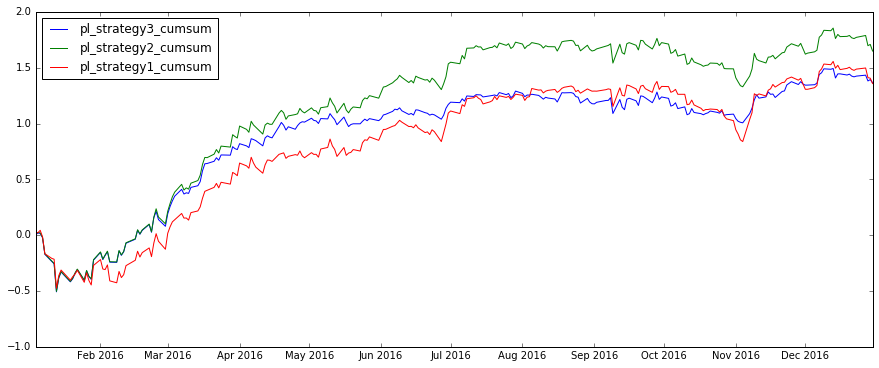

In [131]:
plt.plot(TEST['pl_strategy3_cumsum'])
plt.plot(TEST['pl_strategy2_cumsum'])
plt.plot(TEST['pl_strategy1_cumsum'])
plt.legend(loc='upper left')

In [137]:
Sharpe1 = (252**0.5) *TEST['pl_strategy1'].mean()/TEST['pl_strategy1'].std()
Sharpe2 = (252**0.5) *TEST['pl_strategy2'].mean()/TEST['pl_strategy2'].std()
Sharpe3 = (252**0.5) *TEST['pl_strategy3'].mean()/TEST['pl_strategy3'].std()

In [139]:
Sharpe1, Sharpe2, Sharpe3

(1.5571324022899633, 1.9339721450748113, 1.8477959516820441)

In [141]:
TEST['pl_strategy1_cumsum'][-1], TEST['pl_strategy2_cumsum'][-1], TEST['pl_strategy3_cumsum'][-1]

(1.358739429240625, 1.6501305597655833, 1.365949986280935)